In [3]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import math
from matplotlib.pyplot import *

In [140]:
class Reservoir(object):
    """
    Build a reservoir and evaluate internal states
    
    Parameters:
        n_internal_units = processing units in the reservoir
        spectral_radius = largest eigenvalue of the reservoir matrix of connection weights
        leak = amount of leakage in the reservoir state update (optional)
        connectivity = percentage of nonzero connection weights (unused in circle reservoir)
        input_scaling = scaling of the input connection weights
        noise_level = deviation of the Gaussian noise injected in the state update
        circle = generate determinisitc reservoir with circle topology
    """
    
    def __init__(self, n_internal_units=100, spectral_radius=0.99, leak=None,
                 connectivity=0.3, input_scaling=0.2, noise_level=0.01, circle=False):
        
        # Initialize attributes
        self._n_internal_units = n_internal_units
        self._input_scaling = input_scaling
        self._noise_level = noise_level
        self._leak = leak

        # Input weights depend on input size: they are set when data is provided
        self._input_weights = None

        # Generate internal weights
        if circle:
            self._internal_weights = self._initialize_internal_weights_Circ(
                    n_internal_units,
                    spectral_radius)
        else:
            self._internal_weights = self._initialize_internal_weights(
                n_internal_units,
                connectivity,
                spectral_radius)


    def _initialize_internal_weights_Circ(self, n_internal_units, spectral_radius):
        
        internal_weights = np.zeros((n_internal_units, n_internal_units))
        internal_weights[0,-1] = spectral_radius
        for i in range(n_internal_units-1):
            internal_weights[i+1,i] = spectral_radius
                
        return internal_weights
    
    
    def _initialize_internal_weights(self, n_internal_units,
                                     connectivity, spectral_radius):

        # Generate sparse, uniformly distributed weights.
        internal_weights = sparse.rand(n_internal_units,
                                       n_internal_units,
                                       density=connectivity).todense()

        # Ensure that the nonzero values are uniformly distributed in [-0.5, 0.5]
        internal_weights[np.where(internal_weights > 0)] -= 0.5
        
        # Adjust the spectral radius.
        E, _ = np.linalg.eig(internal_weights)
        e_max = np.max(np.abs(E))
        internal_weights /= np.abs(e_max)/spectral_radius       

        return internal_weights


    def _compute_state_matrix(self, X, n_drop=0):
        N, T = X.shape
        previous_state = np.zeros((N, self._n_internal_units), dtype=float)

        # Storage
        state_matrix = np.empty((N, T - n_drop, self._n_internal_units), dtype=float)
        for t in range(T):
            X_row = X.shape[0]
            current_input = X[:, t].reshape(X_row,1)
            new_input_weights = self._input_weights.reshape(self._n_internal_units, 1)

            # Calculate state
            state_before_tanh = self._internal_weights.dot(previous_state.T) + new_input_weights.dot(current_input.T)

            # Add noise
            state_before_tanh += np.random.rand(self._n_internal_units, N)*self._noise_level

            # Apply nonlinearity and leakage (optional)
            if self._leak is None:
                previous_state = np.tanh(state_before_tanh).T
            else:
                previous_state = (1.0 - self._leak)*previous_state + np.tanh(state_before_tanh).T

            # Store everything after the dropout period
            if (t > n_drop - 1):
                state_matrix[:, t - n_drop] = previous_state

        return state_matrix


    def get_states(self, X, n_drop=0, bidir=True):
        N, T = X.shape
        if self._input_weights is None:
            self._input_weights = (2.0*np.random.binomial(1, 0.5 , [self._n_internal_units]) - 1.0)*self._input_scaling

        # compute sequence of reservoir states
        states = self._compute_state_matrix(X, n_drop)
    
        # reservoir states on time reversed input
        if bidir is True:
            X_r = X[:, ::-1]
            states_r = self._compute_state_matrix(X_r, n_drop)
            states = np.concatenate((states, states_r), axis=2)

        return states
    
    def getReservoirEmbedding(self, X,pca, ridge_embedding,  n_drop=5, bidir=True, test = False):

        res_states = self.get_states(X, n_drop=5, bidir=True)


        N_samples = res_states.shape[0]
        res_states = res_states.reshape(-1, res_states.shape[2])                   
        # ..transform..
        if test:
            red_states = pca.transform(res_states)
        else:
            red_states = pca.fit_transform(res_states)          
        # ..and put back in tensor form
        red_states = red_states.reshape(N_samples,-1,red_states.shape[1])  

        coeff_tr = []
        biases_tr = []   

        for i in range(X.shape[0]):
            ridge_embedding.fit(red_states[i, 0:-1], red_states[i, 1:])
            coeff_tr.append(ridge_embedding.coef_.ravel())
            biases_tr.append(ridge_embedding.intercept_.ravel())
        print(np.array(coeff_tr).shape,np.array(biases_tr).shape)
        input_repr = np.concatenate((np.vstack(coeff_tr), np.vstack(biases_tr)), axis=1)
        return input_repr

Text(0.5, 1.0, 'A sample of data')

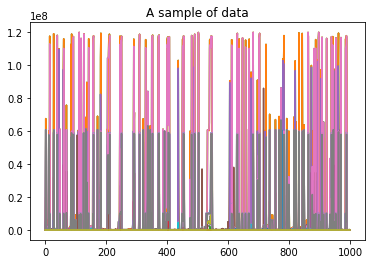

In [141]:
data = pd.read_csv("Datasets/ids2018_1502thurs_train_60.csv", header=None)
data.head()

# plot some of it
figure(10).clear()
plot(data[0:1000])
title('A sample of data')

In [142]:
num_col = data.shape[1]
num_row = data.shape[0]

X_data = data.iloc[:, 0:num_col-1]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_data.values)
X = pd.DataFrame(np.nan_to_num(x_scaled))

y = data.iloc[:, num_col-1]

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Working with 1% of the data for now because my laptop sucks
X_train2 = X_train.sample(frac=0.0001, replace=True, random_state=1)
y_train2 = y_train.sample(frac=0.0001, replace=True, random_state=1)
X_test2 = X_test.sample(frac=0.0001, replace=True, random_state=1)
y_test2 = y_test.sample(frac=0.0001, replace=True, random_state=1)
print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)

(12, 78) (12,)
(12, 78) (12,)


In [149]:
y_train2, y_test2

(59341     0
 197535    1
 189200    0
 209486    0
 151432    0
 243250    0
 207327    0
 211645    0
 240488    1
 75372     0
 79285     0
 192076    1
 Name: 78, dtype: int64, 117231    0
 153593    0
 78167     0
 186395    0
 148285    0
 137883    0
 74798     0
 224855    0
 134136    0
 63053     0
 149912    0
 225977    1
 Name: 78, dtype: int64)

In [150]:
pca = PCA() #n_components gives number of components to keep for linear dimensionality reduction
ridge_embedding = Ridge(alpha=10, fit_intercept=True)
readout = Ridge(alpha=5)

In [151]:
res = Reservoir(n_internal_units=450, spectral_radius=0.6, leak=0.6,
                 connectivity=0.25, input_scaling=0.1, noise_level=0.01, circle=False)

In [152]:
input_repr = res.getReservoirEmbedding(np.array(X_train2), pca, ridge_embedding,  n_drop=5, bidir=True, test = False)
input_repr

(12, 767376) (12, 876)


array([[ 6.45038560e-01, -6.25419108e-02, -2.30198120e-02, ...,
         1.44224781e-06,  2.34243278e-06,  2.13524046e-16],
       [ 4.84873684e-01, -5.61336076e-02, -2.57952637e-02, ...,
        -4.67258684e-07,  2.74265114e-06,  2.13524046e-16],
       [ 6.13334410e-02, -2.43191959e-02, -3.93982591e-02, ...,
         5.36353882e-06, -1.37511333e-06,  2.13524046e-16],
       ...,
       [ 4.24263554e-01, -4.26628269e-02,  2.93879885e-02, ...,
        -4.28376294e-07,  9.29542016e-07,  2.13524046e-16],
       [ 4.45341656e-01, -1.78306429e-02, -7.56386002e-02, ...,
         8.21189225e-07,  1.94125691e-06,  2.13524046e-16],
       [ 4.63117393e-01, -4.11492513e-02, -2.85009790e-02, ...,
         4.24581190e-06, -2.39146258e-06,  2.13524046e-16]])

In [153]:
input_repr_te = res.getReservoirEmbedding(np.array(X_test2), pca, ridge_embedding,  n_drop=5, bidir=True, test = True)
input_repr_te

(12, 767376) (12, 876)


array([[ 4.00953790e-01, -4.14265470e-02,  1.33232446e-02, ...,
        -3.10711090e-04, -1.37552434e-03,  4.36187010e-04],
       [ 4.12922983e-01, -6.79106297e-02,  1.58341710e-02, ...,
         2.10491877e-04,  2.65024689e-05, -9.05233242e-04],
       [ 6.17534459e-02, -2.60553574e-02, -4.06990715e-02, ...,
         2.12286635e-03,  2.58503376e-03, -3.06554654e-04],
       ...,
       [ 5.89760404e-02, -2.61271059e-02, -4.08264512e-02, ...,
        -5.59523228e-04,  3.81600261e-03,  4.85484304e-04],
       [ 6.37171906e-02, -2.34005523e-02, -3.76727200e-02, ...,
        -6.35305481e-05,  5.26326709e-04,  1.81053209e-03],
       [ 4.74848196e-01, -1.40415080e-02, -4.90599112e-02, ...,
         1.30730043e-03,  1.30052672e-03,  1.88327124e-05]])

In [158]:
readout.fit(input_repr, y_train2)
pred_class = readout.predict(input_repr_te)
print(pred_class)
predictions = [int(round(x)) for x in pred_class]
predictions

[0.28286753 0.26829887 0.2110056  0.24473609 0.15064889 0.24744849
 0.18105078 0.2736949  0.21625872 0.21816606 0.22027307 0.32305489]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [155]:
true_class = list(y_test2)
true_class

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [156]:
def eqArray(a,b):
    return np.where(a == b, 1, 0)

np.sum(list(map(eqArray, predictions, true_class))) / len(true_class)

#accuracy_score(true_class, pred_class, normalize=False)

0.9166666666666666

In [157]:
#f1_score(true_class, pred_class, average='weighted')